# DistilBERT Fine-Tuning with PyTorch

In this notebook, we trained DistilBERT on the large amazon reviews dataset. The dataset was already split into train, validation and test set, which are preprocessed and ready to use from the data_2 file. The dataset is available [here](https://www.kaggle.com/datasets/machharavikiran/amazon-reviews).

The results are discussed in the report.

In [2]:
!export CUDA_LAUNCH_BLOCKING=1
!export TORCH_USE_CUDA_DSA=1

In [3]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score

/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [5]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long) 
        return item

class DistilBertModelBuilder:
    def __init__(self, num_labels, max_length=512):
        # Il tokenizer è definito come attributo della classe qui
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
        self.max_length = max_length
        self.trainer = None

    def train(self, X_train, y_train, X_val, y_val, epochs=3, batch_size=8):
        # Utilizzo del tokenizer definito nell'oggetto
        train_dataset = SentimentDataset(X_train, y_train, self.tokenizer, self.max_length)
        val_dataset = SentimentDataset(X_val, y_val, self.tokenizer, self.max_length)
        
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
        )

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        self.trainer.train()

    def predict(self, X_test, y_test):
        test_dataset = SentimentDataset(X_test, y_test, self.tokenizer, self.max_length)
        predictions = self.trainer.predict(test_dataset)
        print(f"Predictions shape: {predictions.predictions.shape}") 
        print(f"Label shape: {predictions.label_ids.shape}")  
        y_pred = np.argmax(predictions.predictions, axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f'F1 score: {f1:.2f}')
        print(f'Accuracy: {accuracy:.2f}')
        print(classification_report(y_test, y_pred)) 
        return y_pred

    def get_model(self):
        return self.model

In [6]:
from data_2 import X_train, y_train, X_val, y_val

Training data preprocessed successfully!


In [7]:
# get some training data with train test split
from sklearn.model_selection import train_test_split

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

print(len(X_train), len(y_train))

model = DistilBertModelBuilder(num_labels=5)
model.train(X_train, y_train, X_val, y_val, epochs=3, batch_size=8)

5400 5400


/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: d-bedini2 (bedo). Use `wandb login --relogin` to force relogin


/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,1.616900
20,1.613000
30,1.613500
40,1.608200
50,1.609000
60,1.613700
70,1.602900
80,1.609100
90,1.607000
100,1.604400


/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [8]:
from data_2 import X_test_balanced, y_test_balanced, X_test_real, y_test_real

Predictions shape: (415, 5)
Label shape: (415,)
F1 score: 0.72
Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.63      0.57      0.60        30
           1       0.29      0.47      0.36        15
           2       0.29      0.55      0.38        20
           3       0.26      0.40      0.32        50
           4       0.93      0.77      0.84       300

    accuracy                           0.69       415
   macro avg       0.48      0.55      0.50       415
weighted avg       0.77      0.69      0.72       415

              precision    recall  f1-score   support

    Negative       0.67      0.76      0.71        45
     Neutral       0.29      0.55      0.38        20
    Positive       0.97      0.90      0.93       350

    accuracy                           0.87       415
   macro avg       0.64      0.74      0.67       415
weighted avg       0.90      0.87      0.88       415



/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Predictions shape: (415, 5)
Label shape: (415,)
F1 score: 0.76
Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.70      0.42      0.53        45
           1       0.00      0.00      0.00         0
           2       0.29      0.55      0.38        20
           3       0.00      0.00      0.00         0
           4       0.98      0.70      0.82       350

    accuracy                           0.66       415
   macro avg       0.39      0.33      0.34       415
weighted avg       0.92      0.66      0.76       415



/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

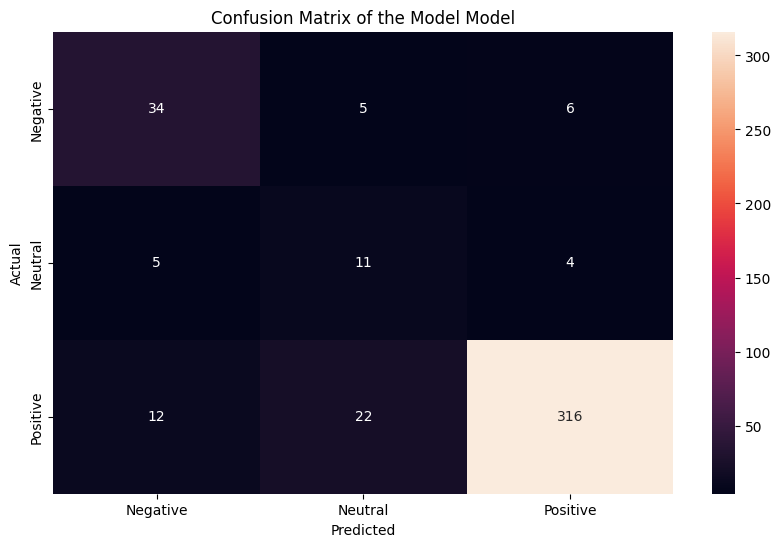

/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Predictions shape: (415, 5)
Label shape: (415,)
F1 score: 0.72
Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.63      0.57      0.60        30
           1       0.29      0.47      0.36        15
           2       0.29      0.55      0.38        20
           3       0.26      0.40      0.32        50
           4       0.93      0.77      0.84       300

    accuracy                           0.69       415
   macro avg       0.48      0.55      0.50       415
weighted avg       0.77      0.69      0.72       415



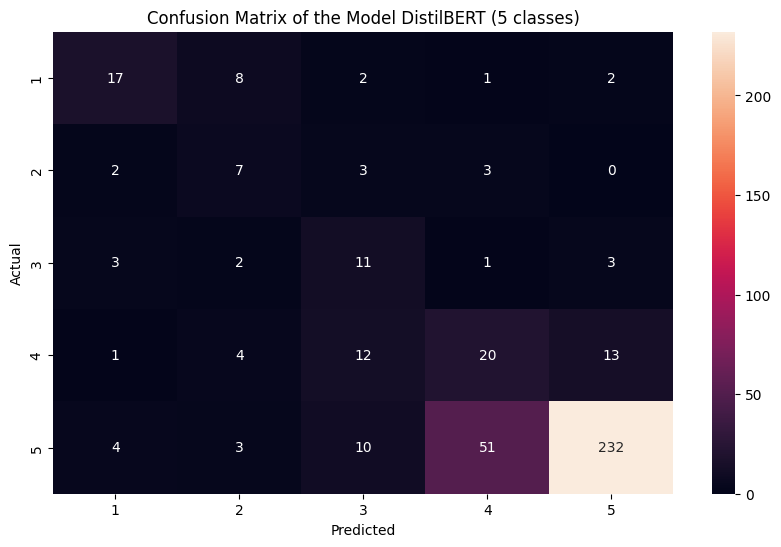

In [9]:
from utils import plot_confusion_matrix, metrics_with_three_classes

metrics_with_three_classes(model, X_test_real, y_test_real, "DistilBERT (3 classes)")
plot_confusion_matrix(model, X_test_real, y_test_real, "DistilBERT (5 classes)" )

/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Predictions shape: (1500, 5)
Label shape: (1500,)
F1 score: 0.51
Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       300
           1       0.43      0.39      0.41       300
           2       0.37      0.39      0.38       300
           3       0.48      0.43      0.45       300
           4       0.68      0.77      0.72       300

    accuracy                           0.52      1500
   macro avg       0.51      0.52      0.51      1500
weighted avg       0.51      0.52      0.51      1500

              precision    recall  f1-score   support

    Negative       0.75      0.72      0.74       600
     Neutral       0.37      0.39      0.38       300
    Positive       0.80      0.81      0.81       600

    accuracy                           0.69      1500
   macro avg       0.64      0.64      0.64      1500
weighted avg       0.70      0.69      0.69      1500



/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Predictions shape: (1500, 5)
Label shape: (1500,)
F1 score: 0.56
Accuracy: 0.45
              precision    recall  f1-score   support

           0       0.83      0.41      0.55       600
           1       0.00      0.00      0.00         0
           2       0.37      0.39      0.38       300
           3       0.00      0.00      0.00         0
           4       0.90      0.52      0.66       600

    accuracy                           0.45      1500
   macro avg       0.42      0.26      0.32      1500
weighted avg       0.77      0.45      0.56      1500



/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

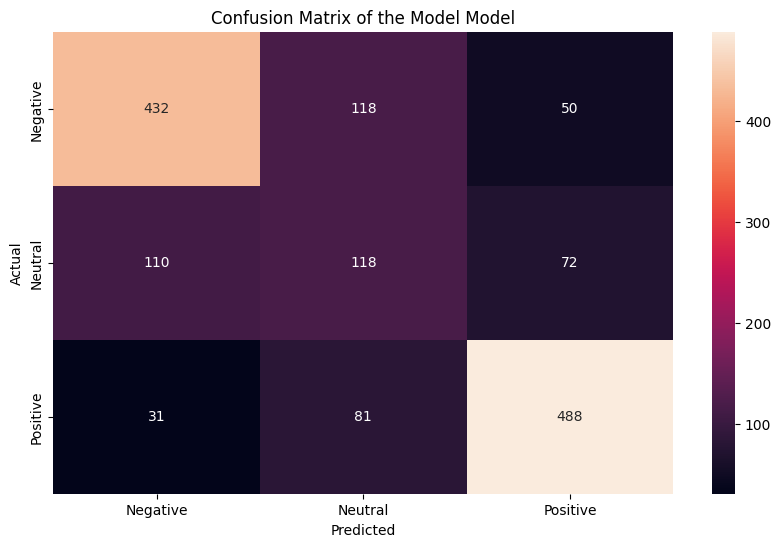

/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Predictions shape: (1500, 5)
Label shape: (1500,)
F1 score: 0.51
Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       300
           1       0.43      0.39      0.41       300
           2       0.37      0.39      0.38       300
           3       0.48      0.43      0.45       300
           4       0.68      0.77      0.72       300

    accuracy                           0.52      1500
   macro avg       0.51      0.52      0.51      1500
weighted avg       0.51      0.52      0.51      1500



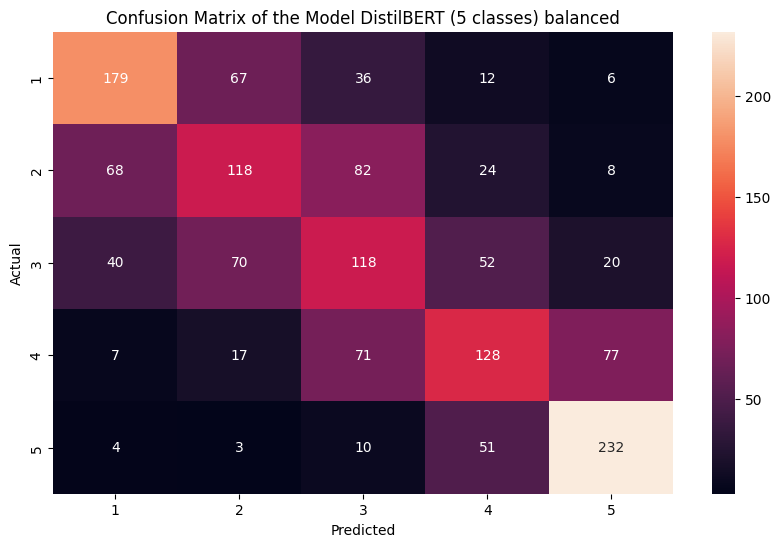

In [10]:
metrics_with_three_classes(model, X_test_balanced, y_test_balanced, "DistilBERT (3 classes) balanced")
plot_confusion_matrix(model, X_test_balanced, y_test_balanced, "DistilBERT (5 classes) balanced" )